**Author:**    `Allison Cheng`

### 1. CNN implementation

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import secrets
import os

cwd = os.getcwd()
data_dir = cwd+ '/data'  # data_dir
train_batch_size = 32
rand_seed = secrets.randbelow(1_000_000_000) # random seed for train/val split
# note that same seed must be used for both to ensure no overlap in train/val data

# Get training images from 'train' directory
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir+'/train',
    labels= 'inferred', # labels generated from sundirectory names
    shuffle=True,  #  if False, sorts the data in alphanumeric order (unbalanced train/val set)
    label_mode= 'int',
    validation_split=0.2,
    subset="training",
    seed=rand_seed,
    image_size=(32, 32),
    batch_size=train_batch_size)

# Get validation images from 'train' directory
val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir+'/train',
    labels= 'inferred',
    shuffle=True,
    label_mode= 'int',
    validation_split=0.2,
    subset="validation",
    seed=rand_seed,
    image_size=(32, 32),
    batch_size=train_batch_size)

# Output list of class names
class_names = train_data.class_names
print(class_names)


Found 520 files belonging to 10 classes.
Using 416 files for training.
Found 520 files belonging to 10 classes.
Using 104 files for validation.
['bridge', 'childs', 'downwarddog', 'mountain', 'plank', 'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']


1.1. Implement the CNN. Plot the training accuracy and validation accuracy over epochs.

In [2]:
# input: RGB image (32*32*3)
# conv1: 16*(3*3), padding valid, stride(1*1)
# conv2: 16*(3*3), padding valid, stride(1*1)
# maxpool1: 2*2, padding valid, stride(2*2)
# conv3: 24*(3*3), padding valid, stride(1*1)
# conv4: 24*(3*3), padding valid, stride(1*1)
# maxpool2: 2*2, padding valid, stride(2*2)
# Flatten
# fully connected layer(10)- softmax

# Use ReLU activation functions for all layers except the final layer- Softmax activation
# Use  Adam optimiser and SparseCategoricalCrossentropy loss
cnn = keras.Sequential(
    [
        layers.Input((32, 32, 3)),  

        layers.Conv2D(16, (3, 3), activation='relu',strides=(1, 1),padding='valid'), 
        layers.Conv2D(16, (3, 3), activation='relu',strides=(1, 1),padding='valid'), 
        layers.MaxPooling2D((2, 2),strides=(2, 2),padding='valid'), 
        layers.Conv2D(24, (3, 3), activation='relu',strides=(1, 1),padding='valid'), 
        layers.Conv2D(24, (3, 3), activation='relu',strides=(1, 1),padding='valid'), 
        layers.MaxPooling2D((2, 2),strides=(2, 2),padding='valid'),         
        layers.Flatten(),
        layers.Dense(10, activation='softmax')
    ], 
)

In [3]:
# compile the model
cnn.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy']) #accuracy
# train the model
history_cnn = cnn.fit(train_data, validation_data=(val_data),
                      epochs=50, batch_size=train_batch_size, shuffle=True)  

Epoch 1/50
13/13 [==============================] - 2s 48ms/step - loss: 21.2426 - accuracy: 0.1322 - val_loss: 4.5900 - val_accuracy: 0.0962
Epoch 2/50
13/13 [==============================] - 0s 29ms/step - loss: 3.2585 - accuracy: 0.1803 - val_loss: 2.5096 - val_accuracy: 0.1346
Epoch 3/50
13/13 [==============================] - 1s 36ms/step - loss: 2.3209 - accuracy: 0.1923 - val_loss: 2.2514 - val_accuracy: 0.1346
Epoch 4/50
13/13 [==============================] - 1s 35ms/step - loss: 2.1816 - accuracy: 0.2236 - val_loss: 2.2182 - val_accuracy: 0.1250
Epoch 5/50
13/13 [==============================] - 1s 36ms/step - loss: 2.1001 - accuracy: 0.2620 - val_loss: 2.2201 - val_accuracy: 0.2115
Epoch 6/50
13/13 [==============================] - 1s 36ms/step - loss: 2.0282 - accuracy: 0.2861 - val_loss: 2.1969 - val_accuracy: 0.2115
Epoch 7/50
13/13 [==============================] - 1s 37ms/step - loss: 1.9434 - accuracy: 0.3365 - val_loss: 2.1373 - val_accuracy: 0.1923
Epoch 8/50
1

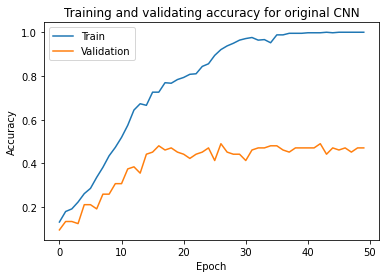

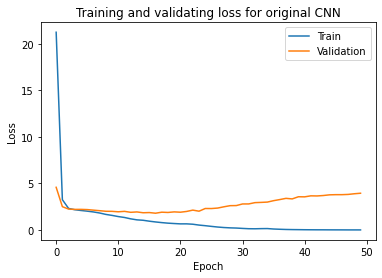

In [4]:
plt.plot(history_cnn.history['accuracy'], label='Train')
plt.plot(history_cnn.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validating accuracy for original CNN')
plt.legend()
plt.show()

plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and validating loss for original CNN')
plt.legend()
plt.show()

1.2. Modify the CNN (see assignment spec for details) and train it on the provided dataset.  Plot the training accuracy and validation accuracy over epochs.

In [5]:
### adding some (a) regularisation and (b) data augmentation
# regularisation: dropout, L2 regularization
# augmentation: random crop, apply contrast adjustments


cnn_modified = keras.Sequential(
    [
        layers.Input((32, 32, 3)),
        layers.Rescaling(1./255),
        layers.RandomCrop(30,30,seed=rand_seed), # random crop
        layers.RandomContrast(0.3, seed=rand_seed), #random contrast
        
        layers.Conv2D(16, (3, 3), activation='relu',strides=(1, 1),padding='valid',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Conv2D(16, (3, 3), activation='relu',strides=(1, 1),padding='valid',
                      kernel_regularizer=tf.keras.regularizers.L2(0.01)), 
        layers.MaxPooling2D((2, 2),strides=(2, 2),padding='valid'),
        layers.Dropout(0.2),  # dropout

        layers.Conv2D(24, (3, 3), activation='relu',strides=(1, 1),padding='valid',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)), 
        layers.Conv2D(24, (3, 3), activation='relu',strides=(1, 1),padding='valid',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)),         
        layers.MaxPooling2D((2, 2),strides=(2, 2),padding='valid'),   
        layers.Dropout(0.2),  # dropout 


        layers.Flatten(),
        layers.Dense(10, activation='softmax')
    ], 
)

# compile the model
cnn_modified.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

# train the model
history_cnn_modified = cnn_modified.fit(train_data, validation_data=(val_data),
                      epochs=50, batch_size=train_batch_size, shuffle=True)

Epoch 1/50
13/13 [==============================] - 6s 61ms/step - loss: 2.9285 - accuracy: 0.0962 - val_loss: 2.8535 - val_accuracy: 0.1635
Epoch 2/50
13/13 [==============================] - 1s 50ms/step - loss: 2.8136 - accuracy: 0.1226 - val_loss: 2.7764 - val_accuracy: 0.0865
Epoch 3/50
13/13 [==============================] - 1s 58ms/step - loss: 2.7310 - accuracy: 0.1394 - val_loss: 2.7006 - val_accuracy: 0.0962
Epoch 4/50
13/13 [==============================] - 1s 47ms/step - loss: 2.6545 - accuracy: 0.1562 - val_loss: 2.6266 - val_accuracy: 0.1154
Epoch 5/50
13/13 [==============================] - 1s 52ms/step - loss: 2.5799 - accuracy: 0.1851 - val_loss: 2.5436 - val_accuracy: 0.1731
Epoch 6/50
13/13 [==============================] - 1s 54ms/step - loss: 2.4639 - accuracy: 0.2284 - val_loss: 2.4444 - val_accuracy: 0.1731
Epoch 7/50
13/13 [==============================] - 1s 49ms/step - loss: 2.3086 - accuracy: 0.2885 - val_loss: 2.2157 - val_accuracy: 0.1827
Epoch 8/50
13

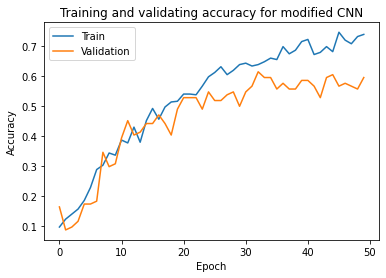

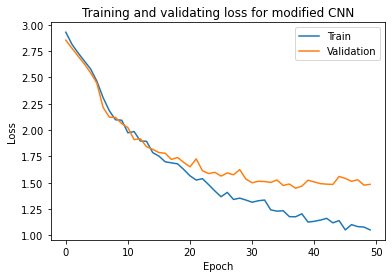

In [6]:
# accuracy plot
plt.plot(history_cnn_modified.history['accuracy'], label='Train')
plt.plot(history_cnn_modified.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validating accuracy for modified CNN')
plt.legend()
plt.show()

# loss plot
plt.plot(history_cnn_modified.history['loss'], label='Train')
plt.plot(history_cnn_modified.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and validating loss for modified CNN')
plt.legend()
plt.show()

### 2. Error anaylsis
Evaluate the CNN model on the test dataset.

In [7]:
test_data = tf.keras.utils.image_dataset_from_directory(
    data_dir+'/test',
    labels= 'inferred',
    shuffle=False,
    label_mode= 'int',
    seed=rand_seed,
    image_size=(32, 32),
    batch_size=train_batch_size)

# training accuracy & loss 
test_results = cnn_modified.evaluate(test_data)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}')

Found 70 files belonging to 10 classes.
3/3 [==============================] - 0s 7ms/step - loss: 1.5895 - accuracy: 0.6000
Test results - Loss: 1.5894571542739868 - Accuracy: 0.6000000238418579


In [8]:
# accuracy per-class
from sklearn.metrics import classification_report
y_test=  np.concatenate([y for x, y in test_data], axis=0) 
y_pred_probabilities= cnn_modified.predict(test_data, batch_size=train_batch_size, verbose=1)  # shape (70,10)
y_pred= np.argmax(y_pred_probabilities, axis = 1)

print(classification_report(y_test, y_pred))

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.50      0.57      0.53         7
           2       0.67      0.57      0.62         7
           3       0.67      0.86      0.75         7
           4       0.50      0.71      0.59         7
           5       0.17      0.14      0.15         7
           6       0.44      0.57      0.50         7
           7       0.86      0.86      0.86         7
           8       0.80      0.57      0.67         7
           9       0.80      0.57      0.67         7

    accuracy                           0.60        70
   macro avg       0.62      0.60      0.60        70
weighted avg       0.62      0.60      0.60        70



### 3. Visualisation
Visualise the feature space that the model uses to classify images. 

In [9]:
from sklearn.neighbors import NearestNeighbors

train_paths = train_data.file_paths
test_paths= test_data.file_paths
image_size=(32, 32)


# create a feature extraction model from modified model (exclude the last softmax layer)
feature_extraction_model= keras.Sequential(
    [
        layers.Input((32, 32, 3)),
        layers.Rescaling(1./255),
        layers.RandomCrop(30,30,seed=rand_seed), # random crop
        layers.RandomContrast(0.3, seed=rand_seed), #random contrast
        
        layers.Conv2D(16, (3, 3), activation='relu',strides=(1, 1),padding='valid',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Conv2D(16, (3, 3), activation='relu',strides=(1, 1),padding='valid',
                      kernel_regularizer=tf.keras.regularizers.L2(0.01)), 
        layers.MaxPooling2D((2, 2),strides=(2, 2),padding='valid'),
        layers.Dropout(0.2),  # dropout

        layers.Conv2D(24, (3, 3), activation='relu',strides=(1, 1),padding='valid',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)), 
        layers.Conv2D(24, (3, 3), activation='relu',strides=(1, 1),padding='valid',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)),         
        layers.MaxPooling2D((2, 2),strides=(2, 2),padding='valid'),   
        layers.Dropout(0.2),  # dropout 

        layers.Flatten(name='target_layer'),
    ], 
)




# function to process the input image
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    # Convert the image pixels (32,32) to a float32 numpy array (32, 32, 3)
    array = image.img_to_array(img)
    # Reshape data for the model by adding a dimension & transforming into a "batch" of size (1, 32, 32, 3)
    # 3d input--> 4d:  same as the training process
    array = np.expand_dims(array, axis=0)  #insert axis at position 0 
    return array



# function for feature extraction
def feature_extraction(img_path,size,model):
    feature_extractor = keras.Model(inputs=model.inputs,
                                    outputs=model.get_layer(name="target_layer").output)
    img_array= get_img_array(img_path, size)
    features = feature_extractor(img_array)
    return features



# function to display orginal/neighboring images 
def display_images(img_path,size,img_index):
    img_tensor = get_img_array(img_path, size=size) / 255.
    img_path= img_path.replace(data_dir,"")
    
    if img_index==-1:
        plt.title('Original image: {}'.format(img_path))  
    else:
        plt.title('Neighbor: {}'.format(img_path))

    plt.imshow(img_tensor[0])
    plt.axis('off')
    plt.show()

    
    
# main function to get 5 nearest neighbors
def get_nearest_neighbors(size,model,test_index,test_dirs,train_dirs):
    # extract feature vec from all train imgs + the test img 
    train_feature_vecs=  np.concatenate([feature_extraction(path,size,model) for path in train_dirs], axis=0) 
    test_img_dir= test_dirs[test_index]
    
    # run KNN
    test_feature_vec= feature_extraction(test_img_dir,size,model)
    neigh_model = NearestNeighbors(n_neighbors=5,metric='minkowski',p=2,leaf_size=60) #Euclidean distance 
    neigh_model.fit(train_feature_vecs)  
    (neigh_distances,neighbor_indices)= neigh_model.kneighbors(test_feature_vec)  #(array([[0.5]]), array([[2]]))
    neighbor_indices= neighbor_indices.tolist()[0]
    
    display_images(test_img_dir,size,-1)  # display orginal img
    
    for neighbor_index in neighbor_indices:   # display neighbors
        neigh_path= train_dirs[neighbor_index]
        display_images(neigh_path,size,1)
  

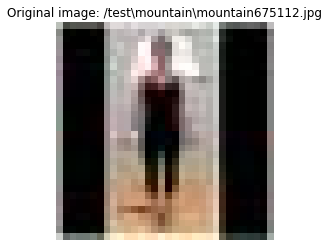

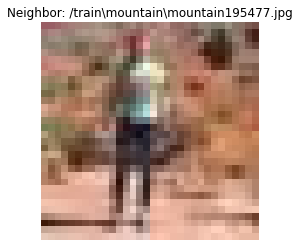

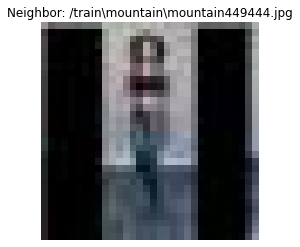

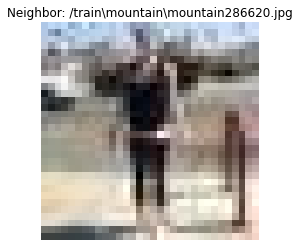

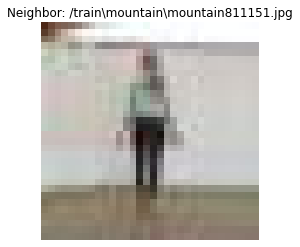

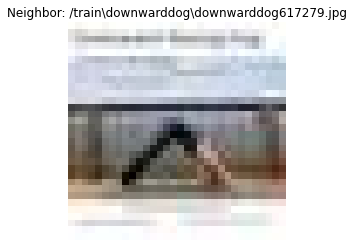

In [10]:
# test run 1
image_size=(32, 32)
get_nearest_neighbors(image_size,feature_extraction_model,25,test_paths,train_paths)

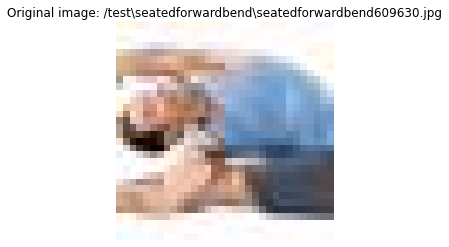

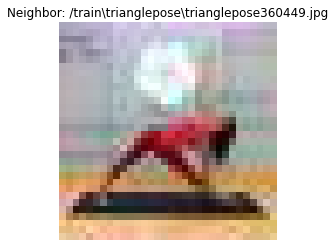

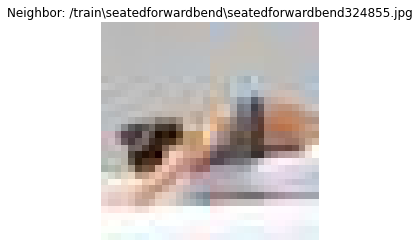

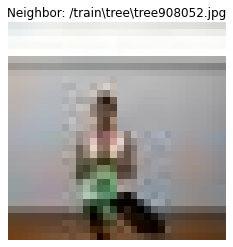

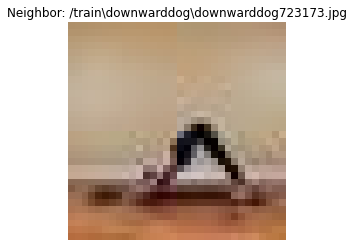

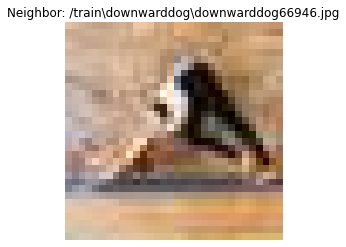

In [11]:
# test run 2
get_nearest_neighbors(image_size,feature_extraction_model,39,test_paths,train_paths)

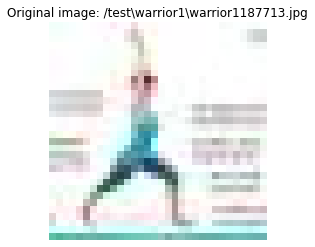

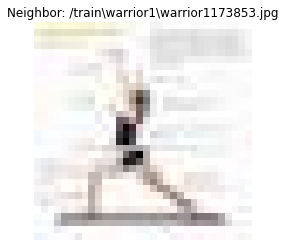

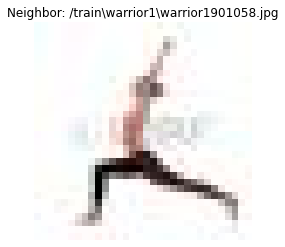

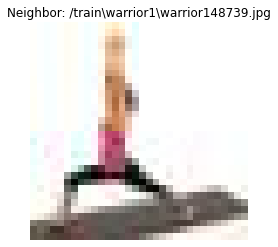

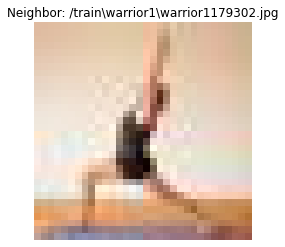

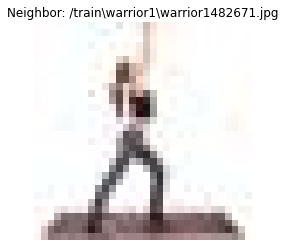

In [12]:
# test run 3
get_nearest_neighbors(image_size,feature_extraction_model,57,test_paths,train_paths)

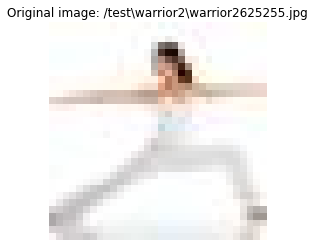

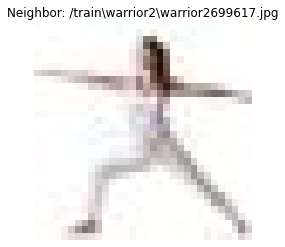

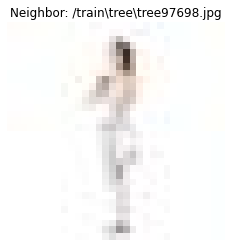

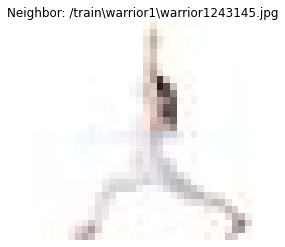

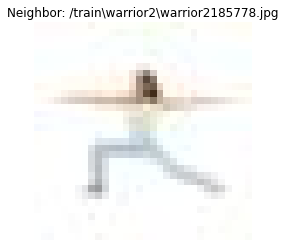

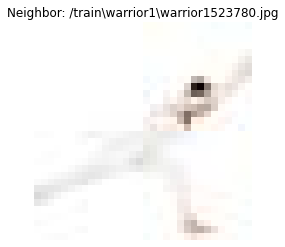

In [13]:
# test run 4
get_nearest_neighbors(image_size,feature_extraction_model,65,test_paths,train_paths)

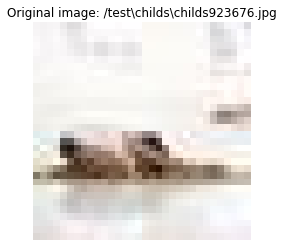

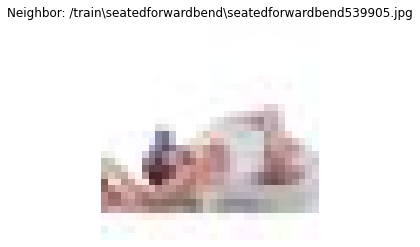

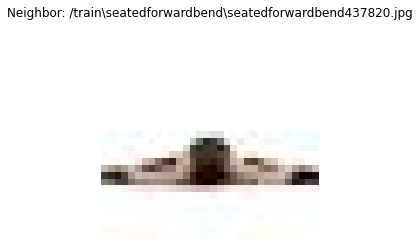

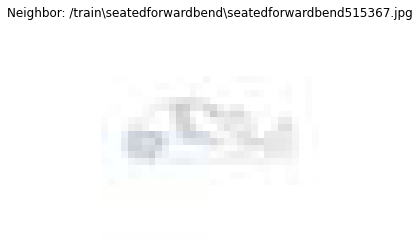

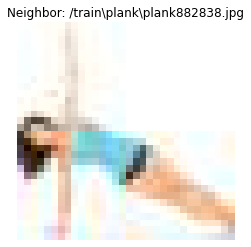

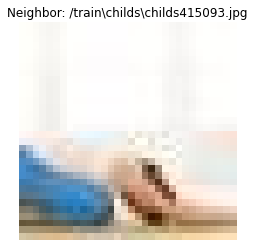

In [14]:
# test run 5
get_nearest_neighbors(image_size,feature_extraction_model,12,test_paths,train_paths)